# Описание задачи

https://www.kaggle.com/competitions/otto-recommender-system

**Цель задачи с Kaggle**  
"Целью этого соревнования является предсказание кликов, добавлений в корзину и заказов в электронной коммерции. Вы создадите многоцелевую рекомендательную систему на основе предыдущих событий в пользовательской сессии.

Ваша работа поможет улучшить опыт покупок для всех участников. Клиенты получат более персонализированные рекомендации, в то время как интернет-ритейлеры могут увеличить свои продажи."

"Решение оценивается на основе Recall@20 для каждого типа действия, и три значения Recall усредняются с весами:
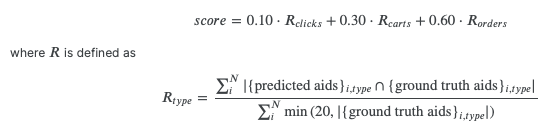
𝑁 - это общее количество сессий в тестовом наборе данных, а предсказанные "aids" - это прогнозы для каждого типа сессии (например, каждая строка в файле - решении), усеченные после первых 20 прогнозов.

Для каждой сессии в тестовых данных ваша задача - предсказать значения "aid" для каждого типа, которые происходят после последней отметки времени (ts) в тестовой сессии. Другими словами, тестовые данные содержат сессии, усеченные по времени, и вы должны предсказать, что произойдет после момента усечения."

**Структура данных**   
"Тренировочные данные содержат полную информацию о сессиях в электронной коммерции. Для каждой сессии в тестовых данных ваша задача - предсказать значения "aid" (идентификаторы товаров) для каждого типа сессии, которые происходят после последней отметки времени (ts) в тестовой сессии."
- train.jsonl - тренировочные данные, содержащие полные данные о сессии
- test.jsonl - тестовые данные, содержащие усеченные данные о сессии  
Внутри каждого
1. session - уникальный идентификатор сессии
2. events - упорядоченная по времени последовательность событий в сессии
3. aid - идентификатор товара (код продукта), связанный с событием
4. ts - Unix-отметка времени события
5. type - тип события, т.е., был ли продукт кликнут, добавлен в корзину пользователя или заказан во время сессии



# IMPORT

In [ ]:
# main_path = '/content/drive/Othercomputers/Mac/Jup.Notebook'

main_path = '/Users/stanislavkrupnov/Jup.Notebook'

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [ ]:
from tqdm import tqdm

# ФУНКЦИИ

In [ ]:
def jsonl_to_df(fn):
    sessions = []
    aids = []
    tss = []
    types = []

    chunks = pd.read_json(fn, lines=True, chunksize=100_000)

    for chunk in chunks:
        for row_idx, session_data in chunk.iterrows():
            num_events = len(session_data.events)
            sessions += ([session_data.session] * num_events)
            for event in session_data.events:
                aids.append(event['aid'])
                tss.append(event['ts'])
                types.append(type2id[event['type']])

    return pd.DataFrame(data={
        'session': sessions,
        'aid': aids,
        'ts': tss,
        'type': types
    })


def plot_text(ax: plt.Axes):
    """
    Вывод текста на графике barplot
    """
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(0, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=11)

# JSON -> PARQUET

In [ ]:
# Для дальнейших преобразований создам два словаря
# Наличие таких типов я узнал на раннем осмотре данных
type2id = {'clicks': 0, 'carts': 1, 'orders': 2}
id2type = {0: 'clicks', 1: 'carts', 2: 'orders'}

with open(f'{main_path}/id2type.pickle', 'wb') as file:
    pickle.dump(id2type, file)
with open(f'{main_path}/type2id.pickle', 'wb') as file:
    pickle.dump(type2id, file)

(['clicks', 'carts', 'orders'], {'clicks': 0, 'carts': 1, 'orders': 2})

In [ ]:
test_json = jsonl_to_df(f'{main_path}/main_dataframes/test.jsonl')

In [ ]:
test_json['ts_ml'] = pd.to_datetime(test_json['ts'], unit='ms')

In [ ]:
test_json.head(3)

,session,aid,ts,type,ts_ml
0,12899779,59625,1661724000278,0,2022-08-28 22:00:00.278
1,12899780,1142000,1661724000378,0,2022-08-28 22:00:00.378
2,12899780,582732,1661724058352,0,2022-08-28 22:00:58.352


**Откину милисекунды, чтобы уменьшить обьем данных, поделив ts на 1000**

In [ ]:
%%time

test_json.ts = (test_json.ts / 1000).astype(np.int32)
test_json.type = test_json.type.astype(np.uint8)
test_json.to_parquet(f'{main_path}/main_dataframes/test_main.parquet',
                     index=False)

CPU times: user 1min 26s, sys: 708 ms, total: 1min 27s
Wall time: 1min 27s


In [ ]:
%%time

train_df = jsonl_to_df('/content/drive/MyDrive/train.jsonl')
train_df.ts = (train_df.ts / 1000).astype(np.int32)
train_df.type = train_df.type.astype(np.uint8)
train_df.to_parquet(f'{main_path}/main_dataframes/train_main.parquet',
                    index=False)

del train_df

CPU times: user 30min 21s, sys: 24.3 s, total: 30min 45s
Wall time: 30min 43s


# EDA

In [ ]:
# подгузка словарей для конвертации числ.столбца type в название типов
with open(f'{main_path}/id2type.pickle', 'rb') as file:
    id2type = pickle.load(file)
with open(f'{main_path}/type2id.pickle', 'rb') as file:
    type2id = pickle.load(file)

Загружаю данные организаторами датасеты

In [ ]:
train = pd.read_parquet(f'{main_path}/main_dataframes/train_main.parquet')

In [ ]:
test = pd.read_parquet(f'{main_path}/main_dataframes/test_main.parquet')

In [ ]:
train.head()

,session,aid,ts,type
0,0,1517085,1659304800,0
1,0,1563459,1659304904,0
2,0,1309446,1659367439,0
3,0,16246,1659367719,0
4,0,1781822,1659367871,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216716096 entries, 0 to 216716095
Data columns (total 4 columns):
 #   Column   Dtype
---  ------   -----
 0   session  int32
 1   aid      int32
 2   ts       int32
 3   type     uint8
dtypes: int32(3), uint8(1)
memory usage: 2.6 GB


In [ ]:
train.isna().sum()

session    0
aid        0
ts         0
type       0
dtype: int64

In [ ]:
test.isna().sum()

session    0
aid        0
ts         0
type       0
dtype: int64

- Пропущенных значений нет

In [ ]:
train.type.unique()

array([0, 1, 2], dtype=uint8)

Заменю идентификаторы типов данных на их полные названия

In [ ]:
train['type'] = train['type'].map(id2type)
test['type'] = test['type'].map(id2type)

**Кол-во действий каждого типа**

In [ ]:
for data, name in zip([train, test], ['train', 'test']):
    type_aid_count = data.groupby('type')['aid'].count()
    total_aid_count = type_aid_count.sum()
    percentage_distribution = round((type_aid_count / total_aid_count) * 100,
                                    2)
    percentage_distribution = percentage_distribution.reset_index()
    percentage_distribution.columns = ['type', '%']

    print(f'{name}\n', percentage_distribution)

train
      type      %
0   carts   7.80
1  clicks  89.85
2  orders   2.35
test
      type      %
0   carts   8.23
1  clicks  90.83
2  orders   0.95


Распределение типов логично, учитывая специфику - действия пользователей в онлайн-магазине

**Кол-во сессий в датасетах**

In [ ]:
train.shape, test.shape

((216716096, 4), (6928123, 4))

- В тренировочном датасете 216716096 взаимодействий(строчек), в тестовом 6928123

In [ ]:
test.session.unique().shape[0] / train.session.unique().shape[0]

0.12959935205091497

- Соотношение кол-ва сессий в тестовом/трен. наборах = 0.12

**Посмотрим распределение кол-ва действий внутри сессий**

In [ ]:
train.groupby('session')['aid'].count().max()

500

In [ ]:
test.groupby('session')['aid'].count().max()

458

In [ ]:
kde_tr = train.groupby('session')['aid'].count()
kde_test = test.groupby('session')['aid'].count()

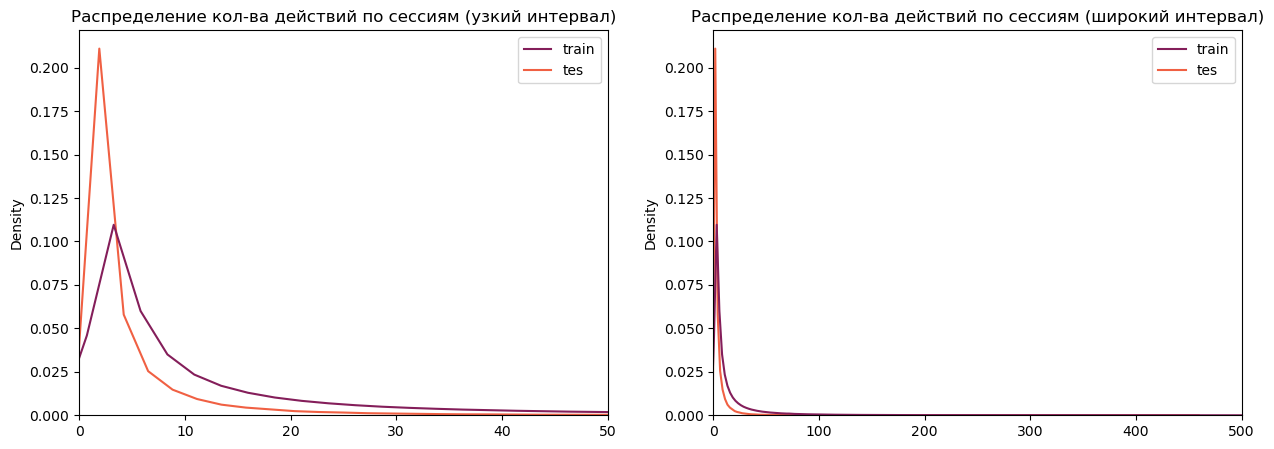

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

sns.kdeplot(data={
    "train": kde_tr,
    "tes": kde_test
},
            common_norm=False,
            palette='rocket',
            ax=axes[0])

axes[0].set(xlim=(0, 50))
axes[0].set_title('Распределение кол-ва действий по сессиям (узкий интервал)')

sns.kdeplot(data={
    "train": kde_tr,
    "tes": kde_test
},
            common_norm=False,
            palette='rocket',
            ax=axes[1])

axes[1].set(xlim=(0, 500))
axes[1].set_title(
    'Распределение кол-ва действий по сессиям (широкий интервал)')

plt.show()

In [ ]:
test.groupby('session')['aid'].count().describe()

count    1.671803e+06
mean     4.144103e+00
std      8.215717e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      4.580000e+02
Name: aid, dtype: float64

In [ ]:
train.groupby('session')['aid'].count().describe()

count    1.289978e+07
mean     1.679999e+01
std      3.357738e+01
min      2.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      1.500000e+01
max      5.000000e+02
Name: aid, dtype: float64

In [ ]:
train.groupby('session')['aid'].count().mean(), test.groupby(
    'session')['aid'].count().mean()

(16.799985178040647, 4.144102504900398)

- Средняя длина сессии (в событиях) в train(16) данных больше в 4 раза по сравнению с test(4) \
Почему так? Для обучения важна статистическая эквивалентность трен. и тест. данных. \
Возможно причина во временных интервалах сессий⬇️

**Проверим датасеты по временным интервалам**

In [ ]:
pd.to_datetime(train['ts'], unit='s').min(), \
pd.to_datetime(train['ts'], unit='s').max()

(Timestamp('2022-07-31 22:00:00'), Timestamp('2022-08-28 21:59:59'))

In [ ]:
pd.to_datetime(test['ts'], unit='s').min(), \
pd.to_datetime(test['ts'], unit='s').max()

(Timestamp('2022-08-28 22:00:00'), Timestamp('2022-09-04 21:59:51'))

- Итак, в тренировочном датасете у нас 4 недели данных, а тестовом - 1, \
причем тестовые данные по времени идут строго после тренировочных \
- Трен. данные - август 2022, тестовые - первая неделя сентября 2022.

In [ ]:
len(set(test.aid.tolist()) - set(train.aid.tolist()))

0

- Кроме того, что данные train,test полностью из разных временных интервалов, \
выходит, что в тестовом датасете нет новых товаров

In [ ]:
train.session.max(), test.session.min()

(12899778, 12899779)

- Также в тестовом наборе (идущем по времени позднее тренировочного) - рассматриваются \
полностью другие пользователи (т.к session - это по сути id пользователя  в рамках моей работы)

**Выводы:**
- Train датасет включает в себя 4 недели наблюдений
- Test датасет включает в себя 1 неделю наблюдений\
Так как в данных в сессию юзера входят все события за ВСЮ историю наблюдений \
(4 и 1 неделя для train и test), то отсюда и вытекает разница между средним кол-вом \
событий в сессии юзера между train и test данными - чем меньше период наблюдений, \
тем и меньше средняя длина сессии в действиях \


**В целом, тренировочный и тестовый датасеты схожи, в них нет координальных отличий**

# Как будет строиться решение

**Я буду строить 2-ух этапную рекомендательную систему:**
1. Первый этап - создание первичных кандидатов (aids-рекомендаций) для каждой сессии и типа действия
2. Второй этап - использование моделей ML для ранжирования первичных кандидатов с целью  
отбора топ-20 для каждой сессии

Изначально буду пробовать создавать по 50 кандидатов для каждой сессии на первом этапе

**На втором этапе для каждого типа действий (click,cart,order) я создам свой тренировочный и тестовый датасет  
с такой структурой:**
- session - идентификаторы сессий
- labels - aids товаров-рекомендаций (для каждой сессии по 50 строк-aid)
- features - столбцы-признаки 
- targets - столбец с обучающими таргетами (в случае трен.датасета)  
**В результате я получу три (для каждого типа) модели ранжирования, и каждая научится  
предсказывать ранги каждой строки(кандидата) внутри группы(сессии), чтобы я мог затем  
оставить топ-20**

Я оценю свое решение локально - взяв holdout часть от оригинальных тренировочных данных,  
а затем получу предсказания на оригинальных тестовых данных - и оценку на leaderboard соревнования